In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20000)
pd.options.mode.chained_assignment = None #Ignore Error: SettingWithCopyWarning
import math
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping
import os
import keras
import tensorflow as tf
from keras.layers import Input, Flatten, Dense, Lambda, Reshape, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.metrics import mse, accuracy
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

#from keras.models import Sequential
#from keras.layers import Dense



keras.backend.clear_session()

# Load the data

In [2]:
df = pd.read_csv('../data/preprocessed/cleaned_data_v8.csv', delimiter=",")
#df = pd.read_csv('../data/preprocessed/cleaned_data_agg_v1.csv', delimiter=",")

key_list = df.keys().tolist()

for x in range(len(key_list)):
    if not df.columns[x] == "datum":
        if not df.columns[x] == "container_id":
            df = df.astype({key_list[x]: "float32"})

# Delete unwanted data; cast datetime

In [3]:
df = df.drop(columns=["height_in_cm"])

# set date as index ancd convert to float
df['datum'] = pd.to_datetime(df['datum'])
df = df.set_index(df['datum'])
df = df.sort_index()
df['datum_float'] = df['datum'].values.astype(float)

# Split into train/test

In [4]:
# create train test partition
training_set = df['2020-05-09 00:00:00':'2021-01-29 23:59:59']
test_set  = df['2021-01-30 00:00:00':]
container_number = 1
training_set = training_set[training_set['container_id']==container_number]
test_set = test_set[test_set['container_id']==container_number]
print('Train Dataset:',training_set.shape)
print('Test Dataset:',test_set.shape)

Train Dataset: (5501, 25)
Test Dataset: (1805, 25)


In [5]:
y_training_set = pd.DataFrame(training_set["hight_delta"].values.tolist(), columns=["hight_delta"])
training_set = training_set.drop(columns=["hight_delta", "datum"])
####
y_test_set = pd.DataFrame(test_set["hight_delta"].values.tolist(), columns=["hight_delta"])
test_set = test_set.drop(columns=["hight_delta", "datum"])

# Prepare the training data

In [6]:
#https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f
#https://analyticsindiamag.com/hands-on-guide-to-lstm-recurrent-neural-network-for-stock-market-prediction/
# Feature Scaling

# ****************** START TUNING *************
timelag = 10 #10
epochs_number = 100 #10
batch_size_number = 32 #32

# ****************** END TUNING *************

train_set = training_set.iloc[:,:].values
y_train_set = y_training_set.iloc[:,:].values

sc = MinMaxScaler(feature_range = (0, 1))
sc1 = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
y_train_set_scaled = sc1.fit_transform(y_train_set)

X_train = []
y_train = []
for i in range(timelag, len(training_set)-1):
    X_train.append(training_set_scaled[i-timelag:i, :])
    y_train.append(y_train_set_scaled[i-1, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)

In [19]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    regressor = Sequential()
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = X_train[0].shape))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    # Compile model
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=["accuracy"])
    
    #first callback method
    #reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, verbose=1,
    #patience=25, min_lr=0.0000001, min_delta=0.0001)
    #default value lr = 0.001
    #callbacks = [reduce_lr]

    # Second callback mehod
    #es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    return regressor

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 50, 100]
epochs = [5, 10, 20, 100, 500]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2, error_score="raise")
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [ ]:
grid_result.cv_results_

# Train the model

Epoch 1/100
172/172 [==============================] - 54s 53ms/step - loss: 0.1890
Epoch 2/100
172/172 [==============================] - 9s 51ms/step - loss: 0.0095
Epoch 3/100
172/172 [==============================] - 9s 51ms/step - loss: 0.0080
Epoch 4/100
172/172 [==============================] - 9s 51ms/step - loss: 0.0083
Epoch 5/100
172/172 [==============================] - 9s 51ms/step - loss: 0.0081
Epoch 6/100
172/172 [==============================] - 9s 51ms/step - loss: 0.0078
Epoch 7/100
172/172 [==============================] - 9s 53ms/step - loss: 0.0080
Epoch 8/100
172/172 [==============================] - 9s 52ms/step - loss: 0.0072
Epoch 9/100
172/172 [==============================] - 10s 59ms/step - loss: 0.0069- ETA:  -
Epoch 10/100
172/172 [==============================] - 9s 52ms/step - loss: 0.0067
Epoch 11/100
172/172 [==============================] - 9s 52ms/step - loss: 0.0073
Epoch 12/100
172/172 [==============================] - 9s 55ms/step - los

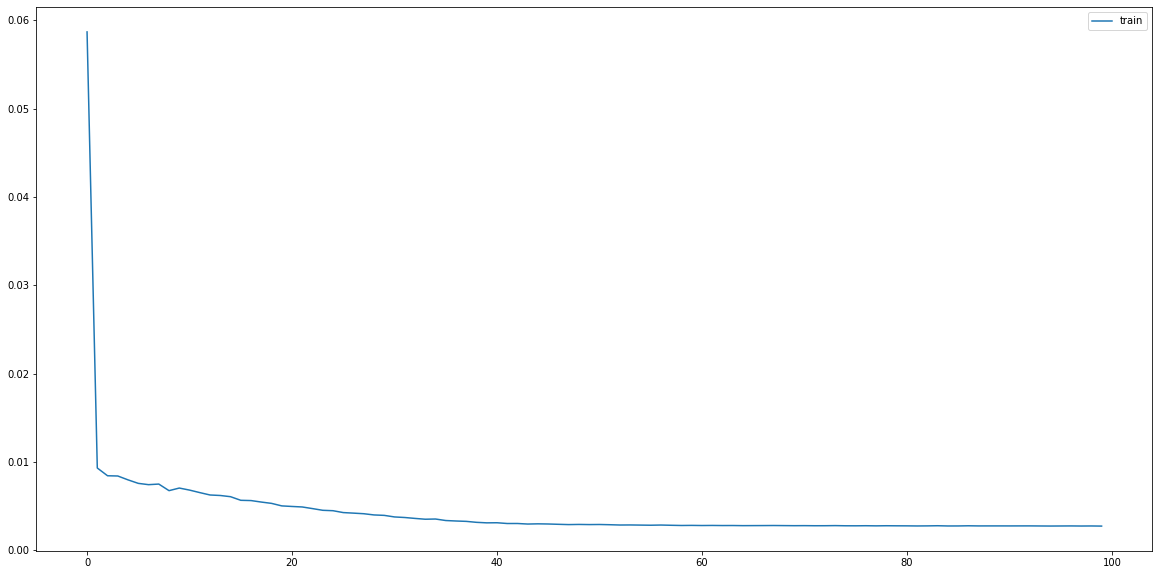

In [8]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = regressor.fit(X_train, y_train, epochs = epochs_number, batch_size = batch_size_number)
#, callbacks = callbacks
# callbacks=[es_callback]
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

# Prepare the test data

In [9]:
test_set = test_set.iloc[:,:].values
y_test_set = y_test_set.iloc[:,:].values

sc = MinMaxScaler(feature_range = (0, 1))
test_set_scaled = sc.fit_transform(test_set)

Y_test = []
X_test = []
for i in range(timelag, len(test_set)-1):
    X_test.append(test_set_scaled[i-timelag:i, :])
    Y_test.append(y_test_set[i-1,0])
X_test, Y_test = np.array(X_test), np.array(Y_test)

# Predict

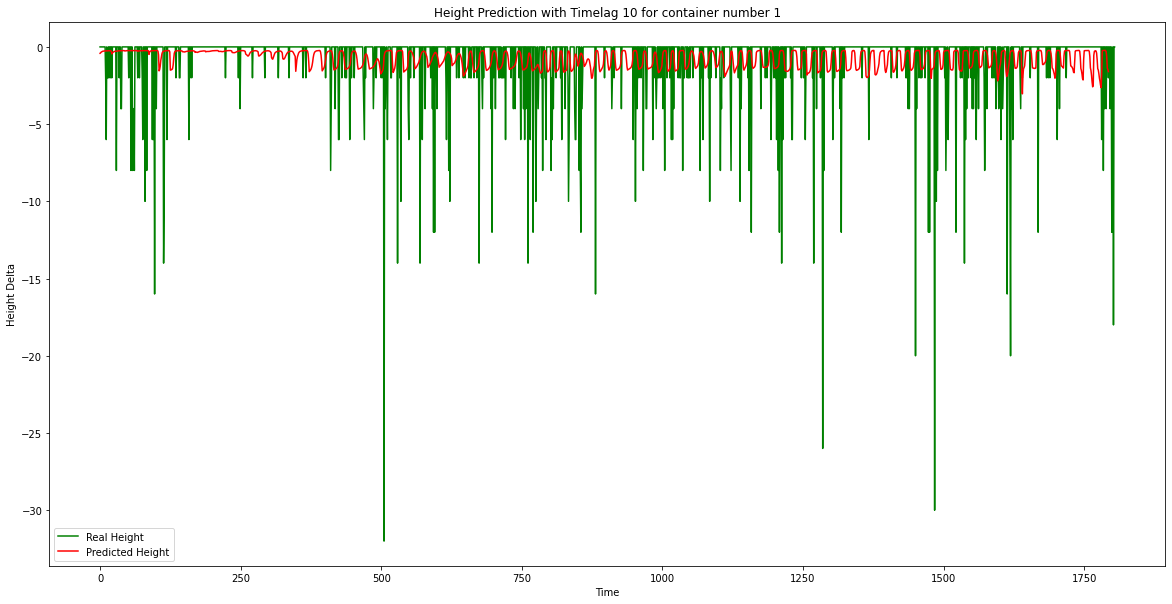

In [12]:
predicted_height = regressor.predict(X_test)
predicted_height = sc1.inverse_transform(predicted_height)

plt.figure(figsize=(20,10))
plt.plot(y_test_set, color = 'green', label = 'Real Height')
plt.plot(predicted_height, color = 'red', label = 'Predicted Height')
plt.title('Height Prediction with Timelag '+ str(timelag) + ' for container number ' +str(container_number))
plt.xlabel('Time')
plt.ylabel('Height Delta')
plt.legend()
plt.show()